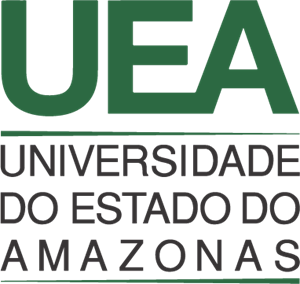

- Módulo: Machine Learning Aplicado I

- Equipe: EAD

- Alunos:
  
  - Andrew da Silva Santos
  - Eberth Felipe Castro da Cruz
  - Eduardo Amorim de Araújo




#Coding

##General Imports

In [113]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Scikit-learn
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
# from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, SCORERS
from sklearn.ensemble import VotingClassifier, RandomForestClassifier

# Configs
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

Install Shap

In [28]:
!pip install shap
import shap

##Get data from Kaggle API
Reference: https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb

###Install Kaggle and Import API

In [3]:
!pip install kaggle

###Get Files

In [4]:
# Kaggle API reference: https://github.com/Kaggle/kaggle-api
def import_kaggle_api_key():
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  from kaggle.api.kaggle_api_extended import KaggleApi

def get_data_from_competition():
  # Kaggle competition link
  # https://www.kaggle.com/c/aml-t2-fw/data
  !kaggle competitions download -c aml-t2-fw
  !ls -la ./
  !unzip ./Dados_Teste.csv.zip
  !unzip ./Dados_Treino.csv.zip
  !ls -la ./

Run this function to import your API.

In order to get you key, got to **Kaggle** > Account > Create New API Token

Import `kaggle.json` file

In [5]:
import_kaggle_api_key()

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [6]:
get_data_from_competition()

# download em ambiente local
# !kaggle competitions download -c aml-t2-fw
# !unzip ./aml-t2-fw.zip


  0% 0.00/2.30M [00:00<?, ?B/s]
100% 2.30M/2.30M [00:00<00:00, 75.8MB/s]
  0% 0.00/28.2k [00:00<?, ?B/s]
100% 28.2k/28.2k [00:00<00:00, 22.9MB/s]
  0% 0.00/114k [00:00<?, ?B/s]
100% 114k/114k [00:00<00:00, 101MB/s]
 44% 9.00M/20.3M [00:00<00:00, 35.5MB/s]
100% 20.3M/20.3M [00:00<00:00, 58.2MB/s]
total 23268
drwxr-xr-x 1 root root     4096 Jul 31 13:48 .
drwxr-xr-x 1 root root     4096 Jul 31 13:46 ..
drwxr-xr-x 4 root root     4096 Jul 16 13:19 .config
-rw-r--r-- 1 root root  2410135 Jul 31 13:48 Dados_Teste.csv.zip
-rw-r--r-- 1 root root 21243109 Jul 31 13:48 Dados_Treino.csv.zip
-rw-r--r-- 1 root root    28910 Jul 31 13:48 Dicionario_de_Dados.csv
drwxr-xr-x 1 root root     4096 Jul 16 13:20 sample_data
-rw-r--r-- 1 root root   117176 Jul 31 13:48 Template_Submissao.csv
Archive:  ./Dados_Teste.csv.zip
  inflating: Dados_Teste.csv         
Archive:  ./Dados_Treino.csv.zip
  inflating: Dados_Treino.csv        
total 108712
drwxr-xr-x 1 root root     4096 Jul 31 13:48 .
drwxr-xr-x 1 root

##Datasets


###Initial view

In [167]:
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')
df_dict_dados = pd.read_csv('./Dicionario_de_Dados.csv')
df_template_sub = pd.read_csv('./Template_Submissao.csv')

In [118]:
def explore_dataset(df_aux):
  delimiter = '--------------------'
  print(df_aux.shape)
  print(delimiter)
  print(round(df_aux.describe(), 2))
  print(delimiter)
  df_aux.info(verbose=True)

Dados de Treino

In [9]:
df_dados_treino.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,92,admit,CTICU,0.541667,0,73.9,2.3,113.0,502.01,0,0,0.4,31.0,2.51,NaN,3.0,6.0,0.0,4.0,168.0,118.0,27.4,0,40.0,NaN,NaN,NaN,NaN,36.0,134.0,39.3,NaN,0,14.1,46.0,32.0,68.0,37.0,68.0,37.0,119.0,72.0,66.0,40.0,89.0,46.0,89.0,46.0,34.0,10.0,100.0,74.0,122.0,64.0,131.0,73.0,131.0,73.0,39.9,37.2,NaN,NaN,68.0,63.0,68.0,63.0,119.0,108.0,NaN,NaN,86.0,85.0,86.0,85.0,26.0,18.0,100.0,74.0,NaN,NaN,131.0,115.0,131.0,115.0,39.5,37.5,2.3,2.3,0.4,0.4,31.0,30.0,8.5,7.4,2.51,2.23,168.0,109.0,19.0,15.0,8.9,8.9,27.4,27.4,NaN,NaN,1.3,1.0,233.0,233.0,4.0,3.4,136.0,134.0,14.1,14.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,90,admit,Med-Surg ICU,0.927778,0,70.2,NaN,108.0,203.01,0,0,NaN,9.0,0.56,1.0,1.0,3.0,0.0,1.0,145.0,120.0,36.9,0,46.0,37.0,37.0,51.0,7.45,33.0,145.0,35.1,NaN,1,12.7,NaN,NaN,95.0,31.0,95.0,31.0,118.0,72.0,NaN,NaN,120.0,38.0,120.0

In [10]:
explore_dataset(df_dados_treino)

(117141, 180)
--------------------
       encounter_id  hospital_id        age        bmi  elective_surgery  \
count     117141.00    117141.00  112653.00  113106.00         117141.00   
mean      213013.98       106.22      62.01      29.12              0.19   
std        38128.78        63.48      16.83       8.28              0.39   
min       147001.00         1.00       0.00      14.84              0.00   
25%       179951.00        50.00      52.00      23.60              0.00   
50%       213051.00       112.00      64.00      27.57              0.00   
75%       246063.00       165.00      75.00      32.82              0.00   
max       279000.00       204.00      89.00      67.81              1.00   

          height     icu_id  pre_icu_los_days  readmission_status     weight  \
count  115286.00  117141.00         117141.00            117141.0  114021.00   
mean      169.60     662.94              0.84                 0.0      83.81   
std        10.84     304.33             

Dados de Teste

In [11]:
df_dados_teste.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,42,35.0,29.060607,0,Caucasian,F,169.0,Emergency Department,Accident & Emergency,1044,admit,Med-Surg ICU,0.161806,0,83.0,NaN,122.0,703.03,0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,91.0,120.0,NaN,0,68.0,NaN,NaN,NaN,NaN,39.0,NaN,34.7,1708.3872,1,NaN,NaN,NaN,86.0,54.0,86.0,54.0,120.0,72.0,NaN,NaN,97.333333,68.333333,97.333333,68.333333,44.0,15.0,100.0,94.0,NaN,NaN,140.0,92.0,140.0,92.0,38.7,34.7,NaN,NaN,83.0,67.0,83.0,67.0,80.0,73.0,NaN,NaN,97.333333,79.0,97.333333,79.0,15.0,15.0,100.0,100.0,NaN,NaN,126.0,103.0,126.0,103.0,34.7,34.7,2.7,2.7,NaN,NaN,8.0,8.0,NaN,NaN,0.87,0.87,108.0,91.0,21.0,21.0,12.6,12.6,37.0,37.0,NaN,NaN,NaN,NaN,259.0,259.0,3.5,3.5,142.0,142.0,18.60,18.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.0,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
1,220057,100,84.0,23.128938,0,Caucasian,F,170.2,Emergency Department,Accident & Emergency,490,admit,Med-Surg ICU,0.040972,0,67.0,NaN,301.0,403.01,0,0,NaN,NaN,NaN,NaN,3.0,6.0,0.0,4.0,232.0,107.0,NaN,0,57.0,NaN,NaN,NaN,NaN,25.0,NaN,36.0,852.59

In [12]:
explore_dataset(df_dados_teste)

(13016, 179)
--------------------
       encounter_id  hospital_id       age       bmi  elective_surgery  \
count      13016.00     13016.00  12516.00  12561.00          13016.00   
mean      212882.75       105.04     61.87     29.02              0.19   
std        37940.12        63.46     16.80      8.09              0.39   
min       147000.00         1.00      0.00     14.84              0.00   
25%       180537.25        47.00     52.00     23.61              0.00   
50%       212676.50       110.00     64.00     27.55              0.00   
75%       245433.25       163.00     75.00     32.61              0.00   
max       278994.00       204.00     89.00     67.81              1.00   

         height    icu_id  pre_icu_los_days  readmission_status    weight  \
count  12794.00  13016.00          13016.00             13016.0  12673.00   
mean     169.64    657.86              0.82                 0.0     83.66   
std       10.81    303.61              2.31                 0.0     

###ETL

Divisão da classe alvo

In [119]:
df_dados_treino['diabetes_mellitus'].value_counts()

0    91807
1    25334
Name: diabetes_mellitus, dtype: int64

#### Balanceamento de dados de treino

Diminuindo Classe **Majoritária**

In [168]:
# ref: https://elitedatascience.com/imbalanced-classes

# Separate majority and minority classes
df_majority = df_dados_treino[df_dados_treino.diabetes_mellitus==0]
df_minority = df_dados_treino[df_dados_treino.diabetes_mellitus==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=60000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
print(df_downsampled.diabetes_mellitus.value_counts())
df_dados_treino = df_downsampled

0    60000
1    25334
Name: diabetes_mellitus, dtype: int64


Pré-processamento de dados de treino e teste

In [121]:
#Transform fields from Object to int
def transform_fields(df, fields):
  label_encoder = LabelEncoder()
  for field in fields:
    df[field] = label_encoder.fit_transform(list(df[field].values))
  return df

#Treat numeric values from dataframe
def str_to_num(df_aux, index):
  for i in index:
    col_name = df_aux.columns[i]
    # df_aux[col_name] = df_aux[col_name].str.replace('.', '')
    # df_aux[col_name] = df_aux[col_name].str.replace(',', '.')
    df_aux[col_name] = pd.to_numeric(df_aux[col_name])
  return df_aux

#Scale numeric values
def apply_scale_for_num(df, cl_begin, cl_end):
  columns_num = df.loc[:, cl_begin:cl_end ].select_dtypes(include=['int64', 'float64']).columns
  df_aux = df[columns_num]

  min_max_scaler = MinMaxScaler().fit(df_aux.values)
  df_aux = min_max_scaler.transform(df_aux.values)
  df[columns_num] = df_aux
  return df

In [169]:
fields_to_tranform = ['ethnicity', 'gender']
df_dados_teste = transform_fields(df_dados_teste, fields_to_tranform)
df_dados_treino = transform_fields(df_dados_treino, fields_to_tranform)

# Change field type
df_dados_teste = str_to_num(df_dados_teste, [3])
df_dados_treino = str_to_num(df_dados_treino, [3])

In [170]:
#Remove columns
rm_columns = ['bmi', 'hospital_id','hospital_admit_source', 'icu_admit_source',
              'icu_id', 'pre_icu_los_days', 'icu_stay_type', 'icu_type', 'apache_2_diagnosis', 
              'readmission_status', 'apache_3j_diagnosis', 'height']

df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

In [171]:
#Replace NaN values with 0
df_dados_teste = df_dados_teste.fillna(0)
df_dados_treino = df_dados_treino.fillna(0)

In [172]:
#Check NaN values
print(np.any(np.isnan(df_dados_teste)))
print(np.any(np.isnan(df_dados_treino)))

False
False


In [173]:
column_begin = 'gcs_eyes_apache'
column_end = 'solid_tumor_with_metastasis'
df_dados_teste = apply_scale_for_num(df_dados_teste.copy(), cl_begin=column_begin, cl_end=column_end)
df_dados_treino = apply_scale_for_num(df_dados_treino.copy(), cl_begin=column_begin, cl_end=column_end)
df_dados_teste

,encounter_id,age,elective_surgery,ethnicity,gender,weight,albumin_apache,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
0,231640,35.0,0,2,0,83.0,0.0,0,0,0.0,0.0,0.00,0.0,0.00,0.000000,1.0,0.0,0.151996,0.674157,0.000000,0.0,0.340,0.000000,0.000000,0.000000,0.000000,0.650000,0.000000,0.874055,0.195991,1.0,0.000000,0.000000,0.000000,0.521212,0.600000,0.521212,0.600000,0.677966,0.473684,0.000000,0.000000,0.528986,0.610119,0.537753,0.610119,0.478261,0.217391,1.00,0.94,0.000000,0.000000,0.603448,0.57500,0.603448,0.57500,0.969925,0.917989,0.000000,0.000000,0.580420,0.592920,0.576389,0.587719,0.487805,0.506944,0.000000,0.000000,0.589899,0.572464,0.597137,0.572464,0.254237,0.127119,1.00,1.00,0.000000,0.000000,0.565022,0.530928,0.565022,0.528205,0.878481,0.882952,0.586957,0.600000,0.000000,0.000000,0.063492,0.070740,0.000000,0.000000,0.078308,0.087544,0.176759,0.315972,0.525,0.538462,0.732558,0.754491,0.718447,0.740,0.000000,0.000000,0.000000,0.000000,0.442735,0.464616,0.500000,0.603448,0.898734,0.928105,0.403646,0.454790,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155386,0.161194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

#### Test category 
Filter some categories to test models

In [64]:
keep_categories = ['identifier', 'labs', 'labs blood gas', 'Target Variable']
keep_columns = df_dict_dados[df_dict_dados['Category'].isin(keep_categories)]
keep_columns_train = keep_columns['Variable Name'].values
keep_columns_test = np.delete(keep_columns_train, len(keep_columns_train)-1)

# reset main dataframes
df_dados_teste = pd.read_csv('./Dados_Teste.csv')
df_dados_treino = pd.read_csv('./Dados_Treino.csv')

df_dados_teste = df_dados_teste[keep_columns_test]
df_dados_treino = df_dados_treino[keep_columns_train]

#remove columns
rm_columns = ['hospital_id']
df_dados_teste.drop(columns=rm_columns, inplace=True)
df_dados_treino.drop(columns=rm_columns, inplace=True)

#Replace NaN values with 0
df_dados_teste = df_dados_teste.fillna(0)
df_dados_treino = df_dados_treino.fillna(0)

#transform fields
column_begin = 'd1_albumin_max'
column_end = 'h1_pao2fio2ratio_min'
df_dados_teste = apply_scale_for_num(df_dados_teste.copy(), cl_begin=column_begin, cl_end=column_end)
df_dados_treino = apply_scale_for_num(df_dados_treino.copy(), cl_begin=column_begin, cl_end=column_end)

df_dados_teste

,encounter_id,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
0,231640,0.586957,0.600000,0.000000,0.000000,0.063492,0.070740,0.000000,0.000000,0.078308,0.087544,0.176759,0.315972,0.525,0.538462,0.732558,0.754491,0.718447,0.740,0.000000,0.000000,0.000000,0.000000,0.442735,0.464616,0.500000,0.603448,0.898734,0.928105,0.403646,0.454790,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.155386,0.161194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,220057,0.000000,0.000000,0.000000,0.000000,0.119048,0.132638,0.611111,0.640777,0.054005,0.060375,0.379705,0.406250,0.500,0.512821,0.720930,0.742515,0.733981,0.756,0.149562,0.174637,0.000000,0.000000,0.384615,0.403624,0.514286,0.620690,0.886076,0.915033,0.198134,0.223238,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149562,0.174637,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,238466,0.739130,0.755556,0.016438,0.016438,0.126984,0.141480,0.759259,0.796117,0.064806,0.072450,0.278232,0.447917,0.700,0.717949,0.883721,0.910180,0.902913,0.930,0.000000,0.000000,0.000000,0.000000,0.435897,0.457440,0.542857,0.655172,0.873418,0.901961,0.177951,0.200499,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.207181,0.214925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,214794,0.000000,0.000000,0.000000,0.000000,0.150794,0.168008,0.712963,0.747573,0.090009,0.100625,0.230769,0.381944,0.625,0.641026,0.436047,0.419162,0.506796,0.492,0.141826,0.179533,0.000000,0.000000,0.319658,0.335456,0.657143,0.793103,0.873418,0.901961,0.141059,0.158932,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158263,0.164179,0.000000,0.000000,0.431034,0.433526,0.504836,0.506796,0.141826,0.179533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,255804,0.000000,0.000000,0.000000,0.000000,0.111111,0.123795,0.805556,0.844660,0.068407,0.076475

##Machine Learning Algorithms

Algoritmos utilizados para prever a presença de Diabetes em pacientes

### Utility Functions to help the process

In [174]:
def print_model_result(model, X_tr, X_ts, y_tr, y_ts):
  print(f'Acurácia (Treino): {round(accuracy_score(y_tr, model.predict(X_tr)), 2)}')
  print(f'Acurácia (Teste): {round(accuracy_score(y_ts, model.predict(X_ts)), 2)}')
  print(classification_report(y_ts, model.predict(X_ts), target_names=['NO', 'YES']))
  plot_confusion_matrix(model, X_ts, y_ts)

def plot_confusion_matrix(model, X_ts, y_ts):
  fig, ax = plt.subplots(figsize=(10,8))
  cm = confusion_matrix(y_ts, model.predict(X_ts), labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=pd.Series(model.classes_).map({0: 'No', 1: 'Yes'}))
  disp.plot(cmap=plt.cm.Blues, ax=ax)
  plt.show()

def get_samples_for_train_test(X, y, div_size, random):
  X_tr, X_ts, y_tr, y_ts = train_test_split(X, 
                                            y,
                                            stratify = y,
                                            test_size=div_size, 
                                            random_state=random)
  print('Amostras de treino:')
  print(f' * X_train: {X_tr.shape}')
  print(f' * y_train: {y_tr.shape}')

  print('Amostras de teste:')
  print(f' * X_test: {X_ts.shape}')
  print(f' * y_test: {y_ts.shape}')
  return X_tr, X_ts, y_tr, y_ts

def create_knn_model(neighbors, X_tr, X_ts, y_tr, y_ts):
  model = KNeighborsClassifier(n_neighbors=neighbors)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

def create_tree_model(depth, X_tr, X_ts, y_tr, y_ts):
  tree_model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)

  tree_model.fit(X_tr, y_tr)
  print_model_result(tree_model, X_tr, X_ts, y_tr, y_ts)
  return tree_model

def create_logistic_model(X_tr, X_ts, y_tr, y_ts):
  logistic_model = LogisticRegression()
  logistic_model.fit(X_tr, y_tr)
  print_model_result(logistic_model, X_tr, X_ts, y_tr, y_ts)
  return logistic_model

def create_random_forest_model(depth, estimators, X_tr, X_ts, y_tr, y_ts):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

In [175]:
def upload_submit(path, msg):
  !kaggle competitions submit -c aml-t2-fw -f '{path}' -m f"Descrição: {msg}"

def send_submit(df, msg):
  now = datetime.now()
  timestamp = datetime.timestamp(now)
  df.to_csv(f'submit_{timestamp}.csv', index=False)
  upload_submit(f'submit_{timestamp}.csv', msg)


def update_df_template(df, df_result_test):
  df['diabetes_mellitus'] = df_result_test.loc[df_result_test['encounter_id'] == df['encounter_id']]['predict']
  return df

def get_dataframe_for_submission(model):
  df_result = df_dados_teste.copy()
  df_result_template = df_template_sub.copy()
  df_result['predict'] = model.predict_proba(df_result)[:,1]
  df_result_template = df_result_template.apply(lambda x: update_df_template(x, df_result), axis=1)
  df_result_template = df_result_template.astype({'encounter_id': 'int64'})
  return df_result_template

def view_result(df_result_view):
  df_result_view = round(df_result_view, 2)
  plt.figure(figsize = (16,10))
  ax = sns.countplot(x = 'diabetes_mellitus', 
                    data = df_result_view)

  ax.set_title('Previsão de Pacientes Diabéticos')
  ax.set_xlabel('Diabético')
  ax.set_ylabel('Qtd. de pacientes')
  plt.xticks(rotation=45)
  plt.show()

def view_shap_analysis(model, X_ts, X_tr):
  explainer = shap.Explainer(model.predict, X_ts)
  shap_values = explainer(X_tr)
  plt.figure(figsize = (16,10))
  ax = shap.summary_plot(shap_values, 
                        boston_df.columns,
                        plot_type='bar')
  plt.show()

In [176]:
now = datetime.now()
timestamp = datetime.timestamp(now)
print(f"submit_{timestamp}.csv")
  

submit_1627751117.175734.csv


### Treinamento dos Modelos

In [177]:
X = df_dados_treino.loc[:,'encounter_id':'solid_tumor_with_metastasis'].to_numpy()

y = df_dados_treino['diabetes_mellitus'].to_numpy()

In [178]:
X_train, X_test, y_train, y_test = get_samples_for_train_test(X, y, div_size=0.25, random=0)

Amostras de treino:
 * X_train: (64000, 167)
 * y_train: (64000,)
Amostras de teste:
 * X_test: (21334, 167)
 * y_test: (21334,)


#### KNN - k vizinhos mais próximos
Treino do Modelo utilizando a algoritmo KNN

****************** KNN ******************
Acurácia (Treino): 0.68
Acurácia (Teste): 0.54
              precision    recall  f1-score   support

          NO       0.53      0.70      0.60      6334
         YES       0.56      0.39      0.46      6333

    accuracy                           0.54     12667
   macro avg       0.55      0.54      0.53     12667
weighted avg       0.55      0.54      0.53     12667



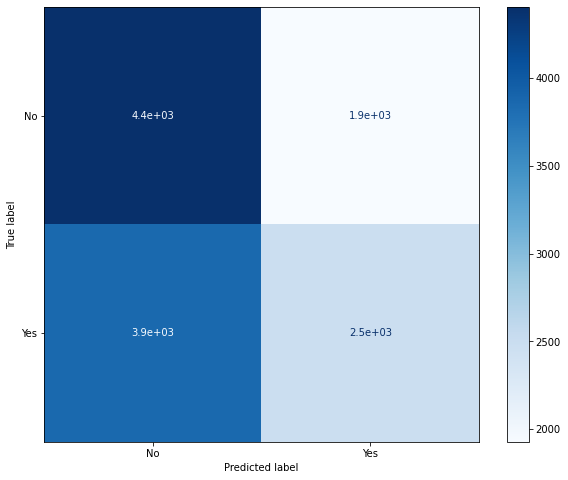

In [133]:
print('****************** KNN ******************')

knn_model = create_knn_model(neighbors=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

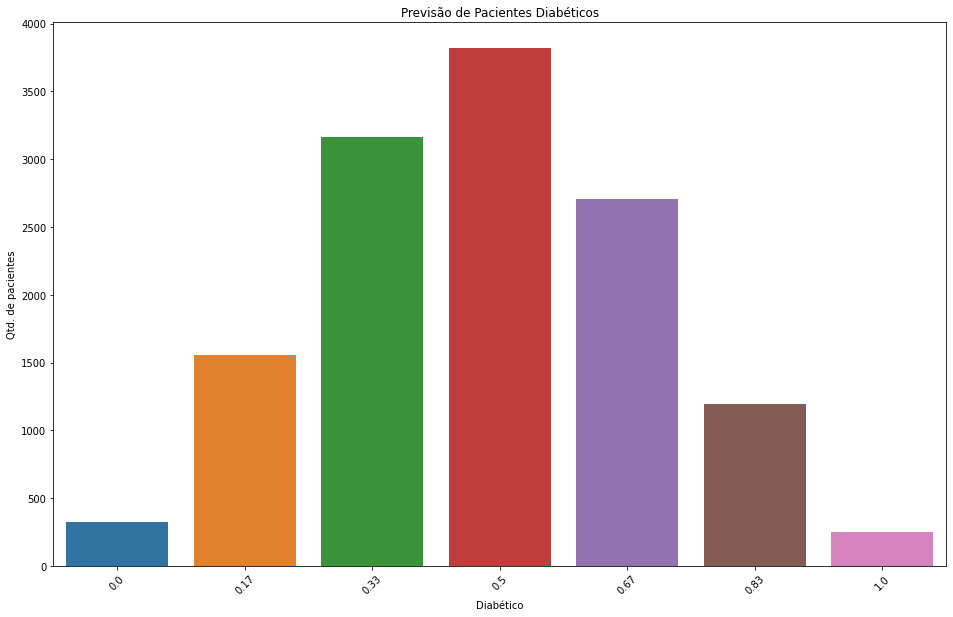

In [134]:
result_knn = get_dataframe_for_submission(knn_model)
view_result(result_knn)

In [135]:
# envia para o kagle o df com o resultado gerado
send_submit(result_knn, 'Teste 5 knn: balance through down majority class')

100% 268k/268k [00:02<00:00, 109kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Decision Tree
Treino do Modelo utilizando a algoritmo Árvore de decisão

****************** ARVORE ******************
Acurácia (Treino): 0.75
Acurácia (Teste): 0.74
              precision    recall  f1-score   support

          NO       0.73      0.76      0.74      6334
         YES       0.75      0.72      0.73      6333

    accuracy                           0.74     12667
   macro avg       0.74      0.74      0.74     12667
weighted avg       0.74      0.74      0.74     12667



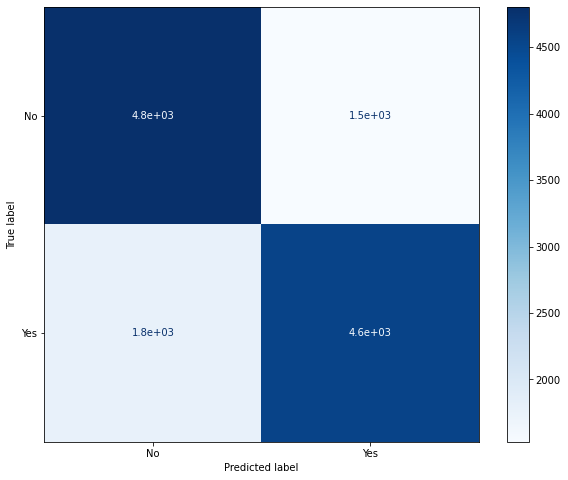

In [137]:
print('****************** ARVORE ******************')

tree_model = create_tree_model(depth=6, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

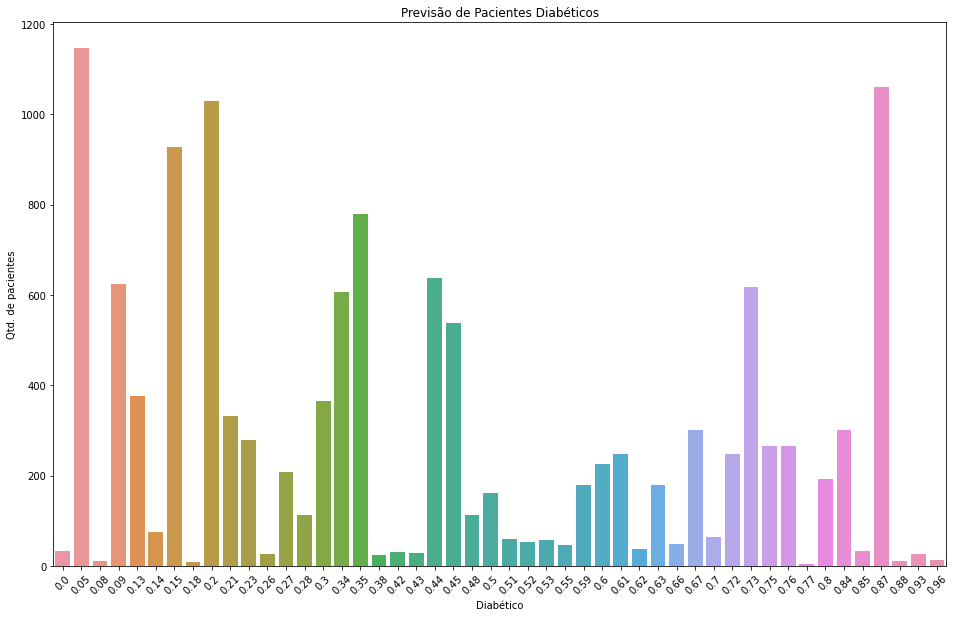

In [138]:
# gera o df para submissão com base no template
result_tree = get_dataframe_for_submission(tree_model)
view_result(result_tree)

In [139]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree, 'Teste 6 decision tree: depth 6, balance through down majority class')

100% 334k/334k [00:01<00:00, 174kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Logistic Regression
Treino do Modelo utilizando a algoritmo de Regressão Logística

****************** Regressão Logística ******************
Acurácia (Treino): 0.58
Acurácia (Teste): 0.59
              precision    recall  f1-score   support

          NO       0.59      0.56      0.57      6334
         YES       0.58      0.61      0.60      6333

    accuracy                           0.59     12667
   macro avg       0.59      0.59      0.59     12667
weighted avg       0.59      0.59      0.59     12667



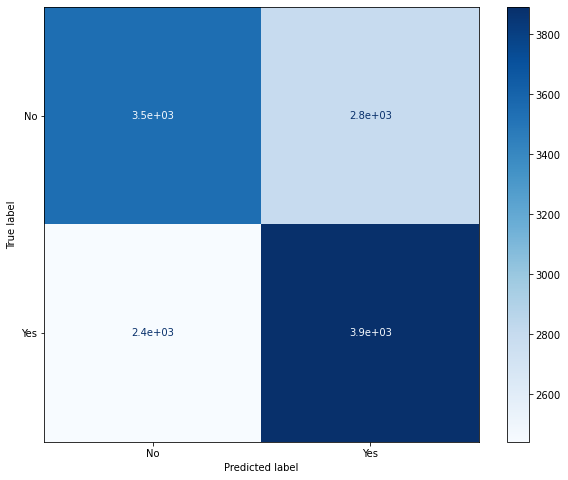

In [140]:
print('****************** Regressão Logística ******************')

logistic_model = create_logistic_model(X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

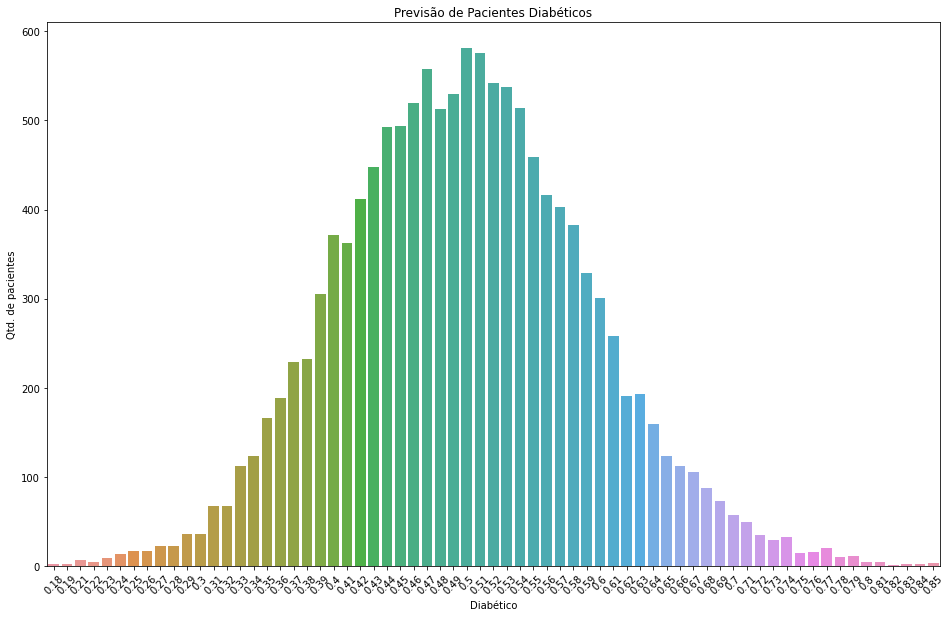

In [141]:
# gera o df para submissão com base no template
result_logistic = get_dataframe_for_submission(logistic_model)
view_result(result_logistic)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic, 'Teste 2 logistic regression')

100% 338k/338k [00:01<00:00, 236kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Random Forest
Treino do Modelo utilizando a algoritmo de Random Forest

****************** Random Forest ******************
Acurácia (Treino): 0.8
Acurácia (Teste): 0.75
              precision    recall  f1-score   support

          NO       0.75      0.76      0.75      6334
         YES       0.75      0.75      0.75      6333

    accuracy                           0.75     12667
   macro avg       0.75      0.75      0.75     12667
weighted avg       0.75      0.75      0.75     12667



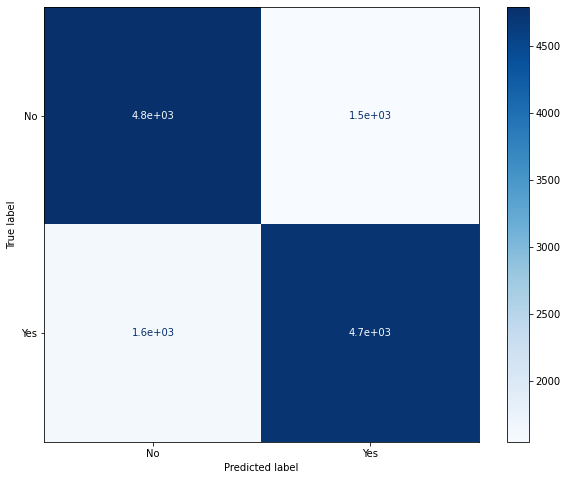

In [145]:
print('****************** Random Forest ******************')

random_forest_model = create_random_forest_model(depth=10, estimators=100, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

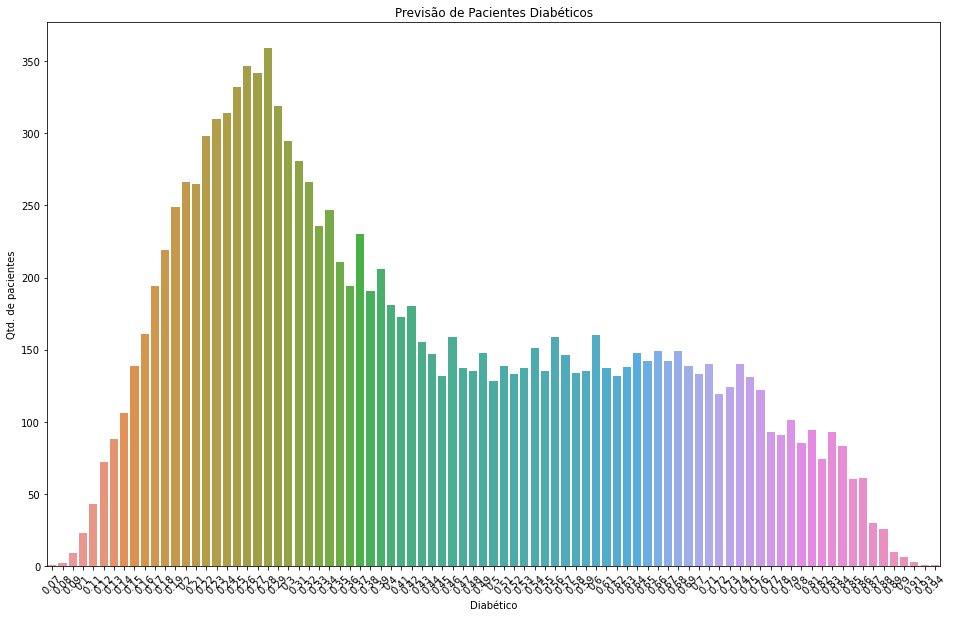

In [146]:
result_random_forest = get_dataframe_for_submission(random_forest_model)
view_result(result_random_forest)

In [147]:
# envia para o kagle o df com o resultado gerado
send_submit(result_random_forest, '9 Random Forest: depth=10, estimators=100; balance through down majority class')

100% 334k/334k [00:02<00:00, 133kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

### Ensemble Learning

Possible metrics to choose

In [ ]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [104]:
#@title Choose metric
work_metric = "roc_auc" #@param ["roc_auc", "accuracy"]

Functions to help Ensemble process

In [179]:
def create_ens_logistic_model():
  model = LogisticRegression()
  return model

def create_ens_decision_tree(depth):
  model = DecisionTreeClassifier(criterion='entropy',
                                    max_depth=depth,
                                    min_samples_split=2,
                                    random_state=0)
  return model

def create_ens_random_forest(depth, estimators):
  model = RandomForestClassifier(n_estimators=estimators, 
                                  criterion='entropy',
                                  max_depth=depth,
                                  min_samples_split=2,
                                  random_state=0)
  return model

def create_cross_validation_model(model, num_splits, scoring_metric, X_tr, y_tr):
  cv = KFold(n_splits = num_splits, 
            shuffle = True, 
            random_state=0)
  n_scores = cross_val_score(model, 
                            X_tr, y_tr, 
                            scoring = scoring_metric, 
                            cv = cv)
  print_cross_model_result(n_scores, scoring_metric)
  return model

def print_cross_model_result(n_scores, scoring_metric):
  print('Cross Validation Result\n')
  print(f'{scoring_metric}: {n_scores}\n')
  print(f'{scoring_metric} (média): {round(np.mean(n_scores), 4)}')
  print(f'{scoring_metric} (desvio padrão): {round(np.std(n_scores), 4)}')

def validate_ens_model(model, X_tr, X_ts, y_tr, y_ts):
  model.fit(X_tr, y_tr)
  print_model_result(model, X_tr, X_ts, y_tr, y_ts)
  return model

#### Logistic Regression 

In [180]:
ens_logistic_model = LogisticRegression()

In [181]:
print('****************** ENSEMBLE Regressão Logística ******************')
ens_logistic_model = create_cross_validation_model(ens_logistic_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Regressão Logística ******************
Cross Validation Result

roc_auc: [0.49638698 0.50632296 0.49659526 0.49734369 0.49695806]

roc_auc (média): 0.4987
roc_auc (desvio padrão): 0.0038


Acurácia (Treino): 0.78
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.78      1.00      0.88     22952
         YES       0.37      0.01      0.02      6334

    accuracy                           0.78     29286
   macro avg       0.58      0.50      0.45     29286
weighted avg       0.69      0.78      0.69     29286



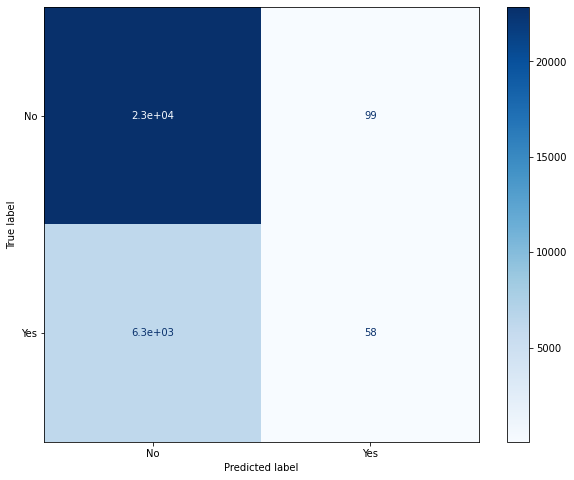

In [ ]:
ens_logistic_model = validate_ens_model(ens_logistic_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

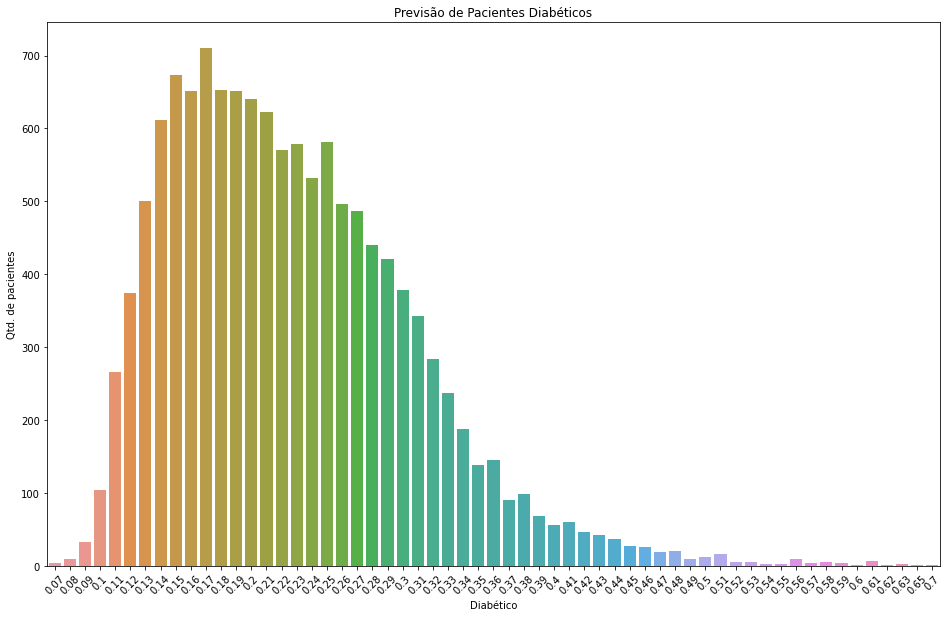

In [ ]:
result_logistic_ens = get_dataframe_for_submission(ens_logistic_model)
view_result(result_logistic_ens)

In [ ]:
# envia para o kagle o df com o resultado gerado
send_submit(result_logistic_ens, 'Ensemble 2 logistic regression')

100% 339k/339k [00:01<00:00, 273kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Decision Tree

In [197]:
ens_tree_model = create_ens_decision_tree(6)

In [198]:
print('****************** ENSEMBLE Árvore de Decisão ******************')
ens_tree_model = create_cross_validation_model(ens_tree_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Árvore de Decisão ******************
Cross Validation Result

roc_auc: [0.80705962 0.80145375 0.80493026 0.80357047 0.81159038 0.80947145
 0.80069709 0.81197985 0.80976161 0.79520431]

roc_auc (média): 0.8056
roc_auc (desvio padrão): 0.0051


Acurácia (Treino): 0.78
Acurácia (Teste): 0.77
              precision    recall  f1-score   support

          NO       0.81      0.87      0.84     15000
         YES       0.64      0.52      0.57      6334

    accuracy                           0.77     21334
   macro avg       0.72      0.70      0.71     21334
weighted avg       0.76      0.77      0.76     21334



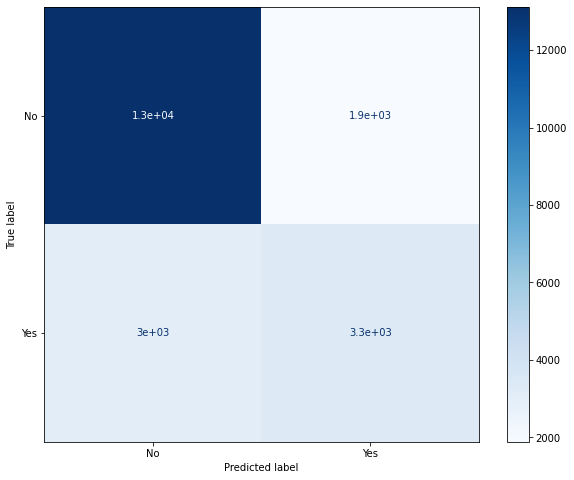

In [199]:
ens_tree_model = validate_ens_model(ens_tree_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

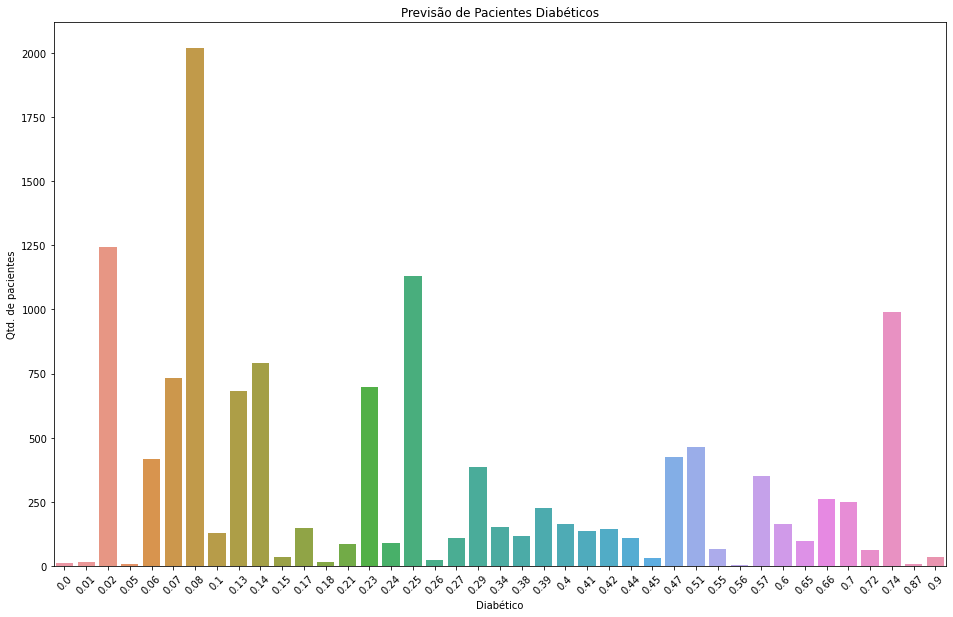

In [200]:
result_tree_ens = get_dataframe_for_submission(ens_tree_model)
view_result(result_tree_ens)

In [153]:
# envia para o kagle o df com o resultado gerado
send_submit(result_tree_ens, 'Ensemble 6 Decision Tree, balance through down majority class')

100% 334k/334k [00:02<00:00, 154kB/s]
Successfully submitted to Machine Learning Aplicado I - Trabalho Final

#### Random Forest

In [206]:
ens_random_forest_model = create_ens_random_forest(16, 100)

In [207]:
print('****************** ENSEMBLE Random Forest ******************')
ens_random_forest_model = create_cross_validation_model(ens_random_forest_model, 5, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Random Forest ******************
Cross Validation Result

roc_auc: [0.82490118 0.82549642 0.83197669 0.8303239  0.82816149]

roc_auc (média): 0.8282
roc_auc (desvio padrão): 0.0027


Acurácia (Treino): 0.93
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.81      0.91      0.85     15000
         YES       0.70      0.48      0.57      6334

    accuracy                           0.78     21334
   macro avg       0.75      0.69      0.71     21334
weighted avg       0.77      0.78      0.77     21334



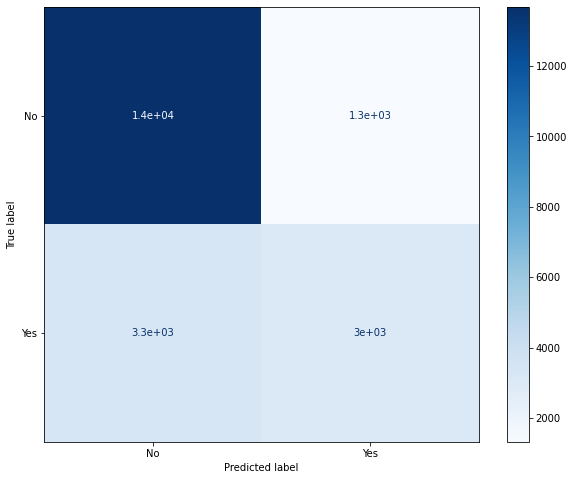

In [208]:
ens_random_forest_model = validate_ens_model(ens_random_forest_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

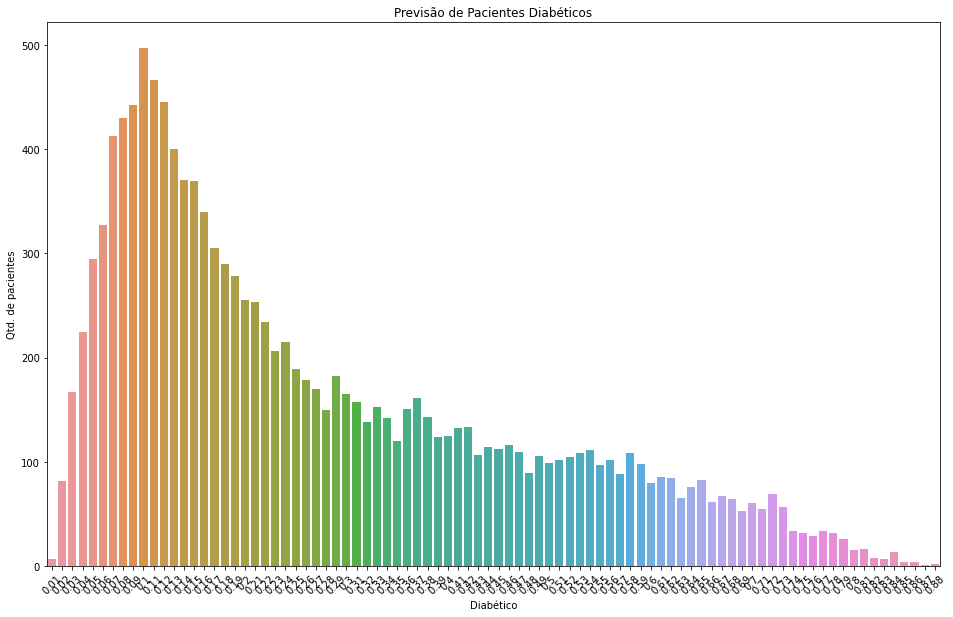

In [209]:
result_random_forest_ens = get_dataframe_for_submission(ens_random_forest_model)
view_result(result_random_forest_ens)

In [210]:
# envia para o kagle o df com o resultado gerado
send_submit(result_random_forest_ens, 'Ensemble 3 Random Forest: depth=16, estimators=100, balance through down majority class')

100% 338k/338k [00:02<00:00, 129kB/s]
400 - Bad Request


#### Soft Voting
Voting Classifier

In [211]:
soft_voting_model = VotingClassifier(estimators=[#('logistic_model', ens_logistic_model),
                                                 ('ens_tree_model', ens_tree_model),
                                                 ('ens_random_forest_model', ens_random_forest_model)], 
                                     voting='soft')

In [212]:
print('****************** ENSEMBLE Soft Voting Classifier ******************')
soft_voting_model = create_cross_validation_model(soft_voting_model, 10, work_metric, X_tr=X_train, y_tr=y_train)

****************** ENSEMBLE Soft Voting Classifier ******************
Cross Validation Result

roc_auc: [0.82695736 0.81929135 0.82433743 0.82290617 0.83152036 0.83167744
 0.82375306 0.83013943 0.83092388 0.81623153]

roc_auc (média): 0.8258
roc_auc (desvio padrão): 0.0051


Acurácia (Treino): 0.86
Acurácia (Teste): 0.78
              precision    recall  f1-score   support

          NO       0.81      0.90      0.85     15000
         YES       0.68      0.50      0.58      6334

    accuracy                           0.78     21334
   macro avg       0.75      0.70      0.72     21334
weighted avg       0.77      0.78      0.77     21334



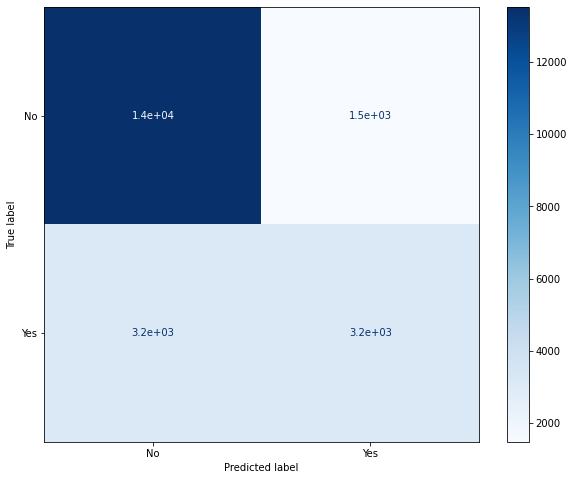

In [213]:
soft_voting_model = validate_ens_model(soft_voting_model, X_tr=X_train, X_ts=X_test, y_tr=y_train, y_ts=y_test)

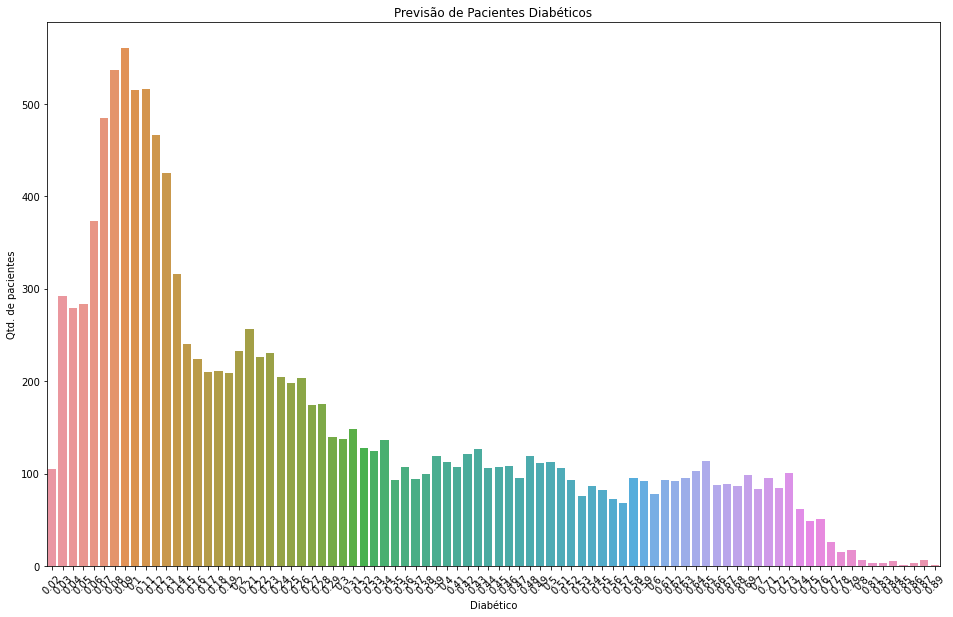

In [214]:
result_soft_voting = get_dataframe_for_submission(soft_voting_model)
view_result(result_soft_voting)

In [215]:
# envia para o kagle o df com o resultado gerado
send_submit(result_soft_voting, 'Ensemble 4 Soft Voting Classifier: balance through down majority class')

100% 338k/338k [00:02<00:00, 140kB/s]
400 - Bad Request
